In [2]:
try:
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
    assert int(torch.__version__.split(".")[0])>1 or (int(torch.__version__.split(".")[0])>2 and int(torch.__version__.split(".")[1]) >= 12), "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    # print(f"torch version: {torch.__version__}")
    # print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.0
torchvision version: 0.18.0


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

/home/joseph/miniconda3/envs/clip/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")

image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [6]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [7]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224 # comes from Table 3 of the ViT paper

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [8]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper (4096) but it's because we're starting small # we can always scale up later

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

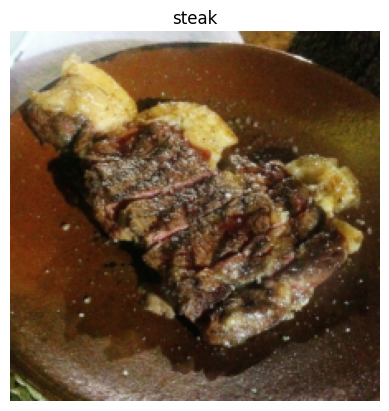

In [10]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);


In [11]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height*width)/patch_size**2)
number_of_patches

196

In [12]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)") # 2D image flattened into patches = 1D sequence of patches

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


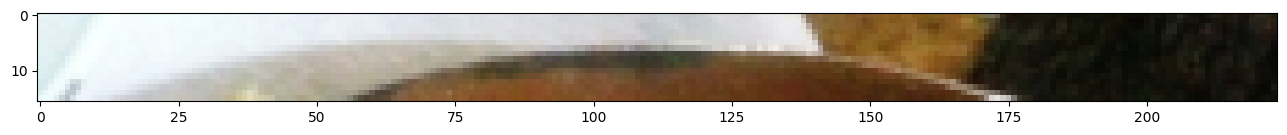

In [13]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size,:,:])

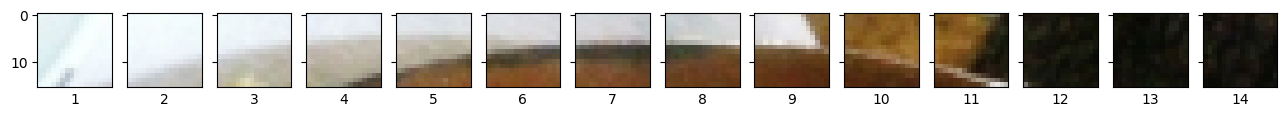

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size//patch_size,                    # one column for each patch
                        sharex=True, sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1) # set the patch label
  axs[i].set_xticks([])
#   axs[i].set_yticks([])
       # keep height index constant, alter the width index

Number of patches per row: 14.0  
Number of patches per column: 14.0  
Total patches : 196.0  
Patch size: 16 pixels x 16 pixels


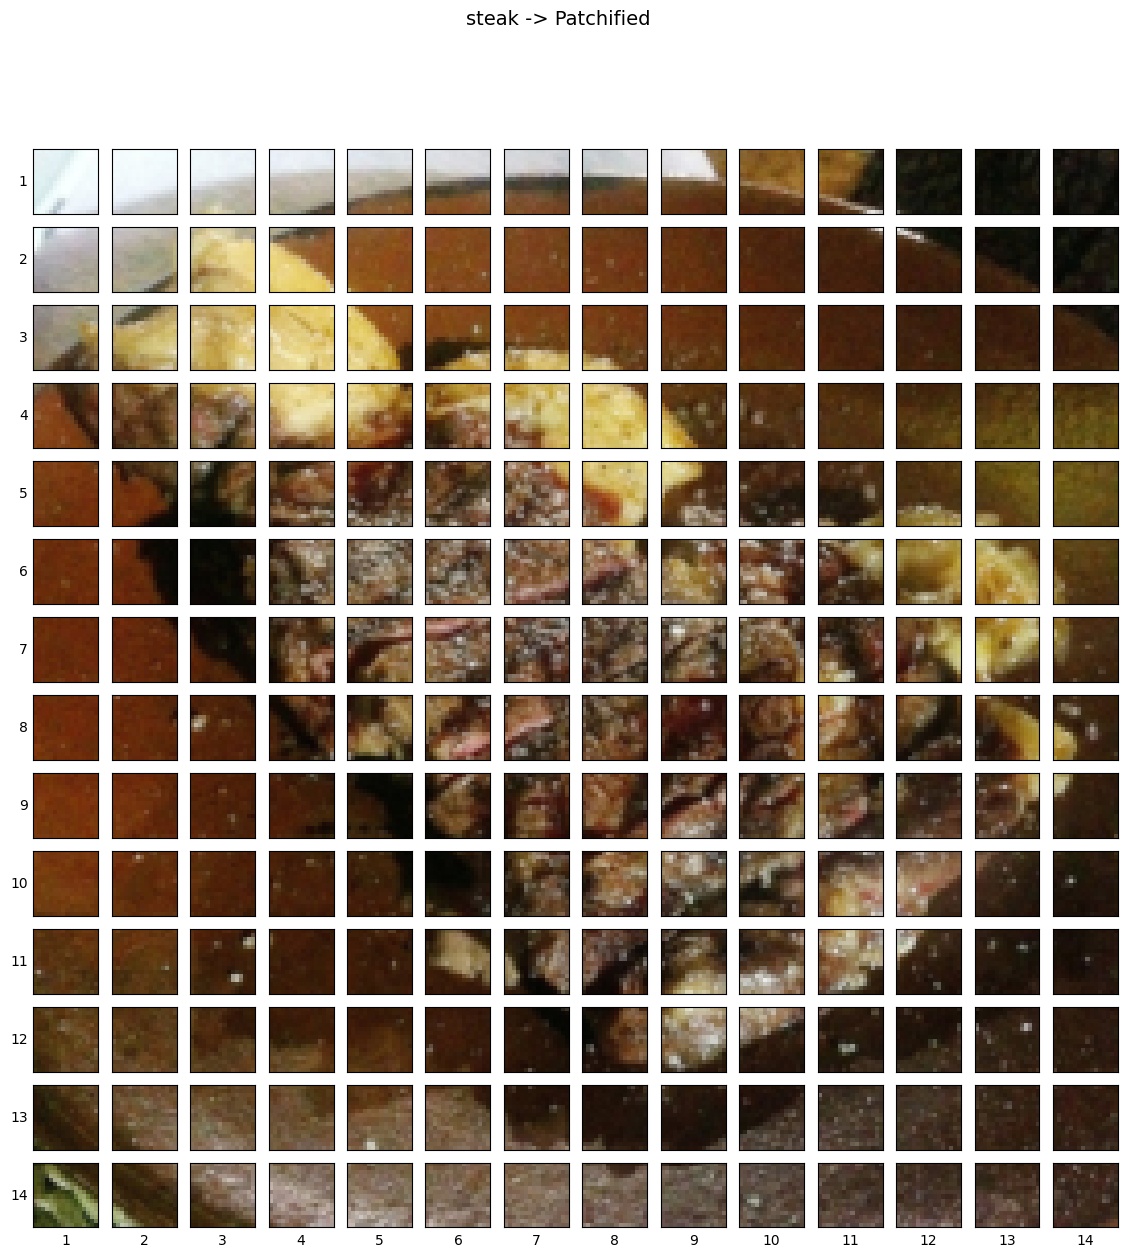

In [15]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
  \nNumber of patches per column: {num_patches}\
  \nTotal patches : {num_patches*num_patches}\
  \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size//patch_size,
                        ncols=img_size//patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)
                        # need int not float

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):   # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
      # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
      axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                      patch_width:patch_width+patch_size, # iterate through width
                                      :])# get all color channels

      # Set up label information, remove the ticks for clarity and set labels to outside
      axs[i, j].set_ylabel(i+1,
                           rotation="horizontal",
                           horizontalalignment="right",
                           verticalalignment="center")
      axs[i, j].set_xlabel(j+1)
      axs[i, j].set_xticks([])
      axs[i, j].set_yticks([])
      axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

In [16]:
# Creating image patches with torch.nn.Conv2d()
from torch import nn
patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

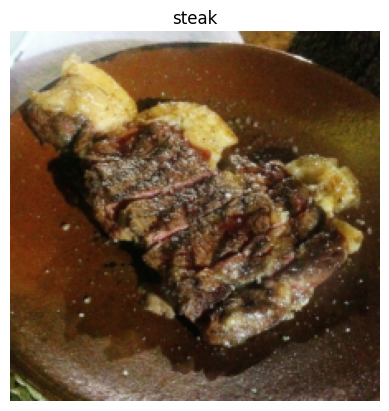

In [17]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [18]:
print(image.shape)
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([3, 224, 224])
torch.Size([1, 768, 14, 14])


In [19]:
image_out_of_conv.requires_grad

True

Showing random convlutional feature maps from indexes: [234, 285, 767, 124, 470]


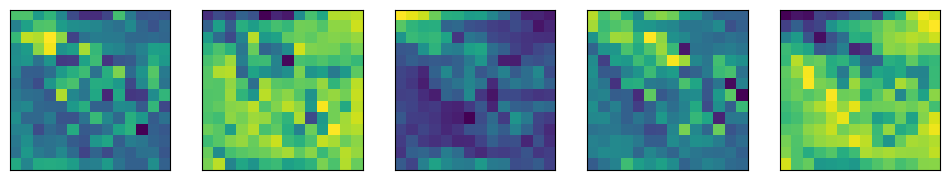

In [20]:
import random
random_indexes = random.sample(range(0,768), k=5)
print(f"Showing random convlutional feature maps from indexes: {random_indexes}") # pick 5 numbers between 0 and the embedding size

fig, axs = plt.subplots(nrows=1,
                        ncols=5,
                        figsize=(12,12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:,idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

(tensor([[[ 0.4720,  0.4569,  0.3627,  0.3329,  0.3450,  0.1972,  0.1450,
            0.2124,  0.1681,  0.1995,  0.0030,  0.0150,  0.0408, -0.0208],
          [ 0.3480,  0.2649,  0.3930,  0.3091,  0.1293,  0.1407,  0.1049,
            0.0949,  0.0869,  0.0535,  0.0806,  0.2279, -0.0084,  0.0353],
          [ 0.2417,  0.3728,  0.2824,  0.2928,  0.2926,  0.0080, -0.0288,
            0.0794,  0.0931,  0.0670,  0.0492,  0.0297,  0.0258,  0.0994],
          [ 0.1512,  0.1639,  0.2057,  0.3360,  0.1675,  0.1915,  0.3541,
            0.3075,  0.1526,  0.0591,  0.0985,  0.1104,  0.0998,  0.1399],
          [ 0.0700,  0.0468,  0.0447,  0.0440,  0.1784,  0.0653,  0.1721,
            0.2511,  0.1725,  0.0268,  0.0608, -0.0088,  0.1059,  0.1353],
          [ 0.0704,  0.1071,  0.0472, -0.0375,  0.1636,  0.1010,  0.1597,
            0.1485,  0.1692,  0.2489,  0.0979,  0.1014,  0.3265,  0.0729],
          [ 0.0567,  0.0700,  0.0094,  0.1024,  0.1629,  0.0403,  0.1480,
            0.1586,  0.0038,  0.

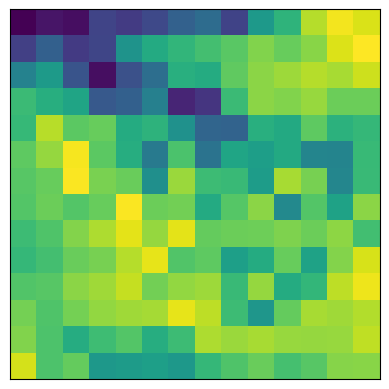

In [21]:
plt.xticks([]), plt.yticks([])

# single feature map (in tensor form)
single_feature_map = image_out_of_conv[:,0,:,:]
single_feature_map, single_feature_map.requires_grad, plt.imshow(image_conv_feature_map.squeeze().detach().numpy())

In [22]:
# Create flatten layer
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,  # flatten feature_map_height (dimension 2)
                           end_dim=3)    # flatten feature_map_width (dimension 3)
flattened_image_out_of_conv = flatten_layer(image_out_of_conv)

flattened_image_out_of_conv.shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


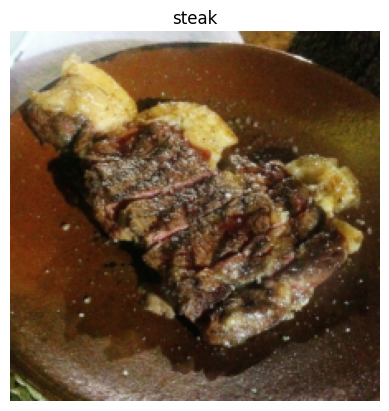

In [23]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")


In [24]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


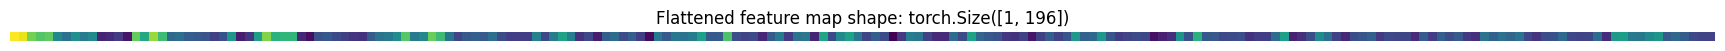

In [25]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [26]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 0.4720,  0.4569,  0.3627,  0.3329,  0.3450,  0.1972,  0.1450,  0.2124,
           0.1681,  0.1995,  0.0030,  0.0150,  0.0408, -0.0208,  0.3480,  0.2649,
           0.3930,  0.3091,  0.1293,  0.1407,  0.1049,  0.0949,  0.0869,  0.0535,
           0.0806,  0.2279, -0.0084,  0.0353,  0.2417,  0.3728,  0.2824,  0.2928,
           0.2926,  0.0080, -0.0288,  0.0794,  0.0931,  0.0670,  0.0492,  0.0297,
           0.0258,  0.0994,  0.1512,  0.1639,  0.2057,  0.3360,  0.1675,  0.1915,
           0.3541,  0.3075,  0.1526,  0.0591,  0.0985,  0.1104,  0.0998,  0.1399,
           0.0700,  0.0468,  0.0447,  0.0440,  0.1784,  0.0653,  0.1721,  0.2511,
           0.1725,  0.0268,  0.0608, -0.0088,  0.1059,  0.1353,  0.0704,  0.1071,
           0.0472, -0.0375,  0.1636,  0.1010,  0.1597,  0.1485,  0.1692,  0.2489,
           0.0979,  0.1014,  0.3265,  0.0729,  0.0567,  0.0700,  0.0094,  0.1024,
           0.1629,  0.0403,  0.1480,  0.1586,  0.0038,  0.2564,  0.0658,  0.1980,
           0.252

In [27]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels=3,
                 patch_size=16,
                 embedding_dim=768):
    
        super().__init__()
        
        self.patch_size = patch_size
        
        # Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        
        # Create a layer to flatten the patches
        self.flatten = nn.Flatten(2,3) # only flatten the feature map dimensions into a single vector

    # Forward Method
    def forward(self, x):
        image_resolution = x.shape[-1] # image resolution check
        assert image_resolution % patch_size == 0, f"Image resolution {image_resolution} must be divisible by patch size {self.patch_size}" # 나뉘어야 함, 아닐 경우 print
        
        # forward pass
        x_flattened = self.flatten(self.patcher(x))
        
        return x_flattened.permute(0,2,1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N (number of patches), P^2•C (embedding_dimension)]
    

In [28]:
set_seeds()

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through PatchEmbedding
print(image.unsqueeze(0).shape)
patch_embedded_image = patchify(image.unsqueeze(0))
print(patch_embedded_image.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 196, 768])


In [29]:
random_input_image = (1,3,224,224)

summary(PatchEmbedding(),
        input_size=random_input_image,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [30]:
patch_embedded_image, patch_embedded_image.shape

(tensor([[[-0.9774,  0.3165, -0.2863,  ...,  0.7592, -0.4357,  0.2859],
          [-0.9457,  0.2263, -0.1818,  ...,  0.6788, -0.4486,  0.3397],
          [-0.9073,  0.2230, -0.0745,  ...,  0.6548, -0.5242,  0.2882],
          ...,
          [-0.3089,  0.0881, -0.1674,  ...,  0.1896, -0.0919,  0.1633],
          [-0.2465,  0.0679, -0.1307,  ...,  0.2124, -0.0784,  0.1908],
          [-0.2418,  0.0056, -0.0883,  ...,  0.1460, -0.1009,  0.1555]]],
        grad_fn=<PermuteBackward0>),
 torch.Size([1, 196, 768]))

In [31]:
# Make learnable class token, add it to the number_of_patches dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token, class_token.shape

(Parameter containing:
 tensor([[[-2.4663e+00,  4.8666e-01,  8.1275e-01,  3.2980e-01, -1.6121e+00,
           -5.7590e-01, -2.2805e-01,  2.9429e-01,  1.1967e-01,  1.5855e+00,
           -2.9088e-01, -1.1353e+00,  1.4488e+00, -1.8383e+00,  8.0495e-01,
           -6.1171e-01, -2.0441e+00,  6.1023e-01,  8.8660e-01,  2.9294e+00,
            1.0633e+00,  1.9676e+00, -2.5913e-01,  4.3707e-01,  2.1142e+00,
            1.0478e+00, -3.8597e-01, -1.0752e+00, -8.8747e-01, -5.0138e-01,
            1.3277e+00,  1.1156e+00, -1.0734e+00, -1.5635e-01, -1.0746e-01,
            7.7948e-01, -1.6764e+00, -9.8822e-01,  5.4542e-01, -1.2481e-01,
           -2.7308e-01, -1.0960e+00, -2.7923e-01,  3.1009e-01, -7.9536e-03,
            7.0091e-01, -9.8159e-02,  1.5224e+00, -3.0794e-01, -8.6819e-01,
           -4.4327e-01,  1.8111e+00,  1.5676e+00, -7.6208e-01,  2.2796e-01,
           -2.7188e-01, -4.5235e-01, -7.5575e-01, -1.0747e+00, -8.1149e-01,
           -1.0482e+00, -3.1524e-01,  3.0454e+00, -4.0238e-01, -2

In [32]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)
print(f'patch_embedded_image_with_class_embedding : {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]')

patch_embedded_image_with_class_embedding : torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [33]:
number_of_patches = int((height*width)/patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create learnable 1D position embedding
position_embedding = nn.Parameter(torch.randn(batch_size,
                                                    number_of_patches+1,
                                                    embedding_dimension,
                                                    requires_grad=True))

# Show first 10 sequences and 10 position embedding values, check shape of position embedding
print(position_embedding[:10])
print(f"Position embedding sequence shape: {position_embedding.shape} -> [batch_size, number_of_patches+1, embedding_dimension]")

tensor([[[-0.7411,  0.8154, -0.3632,  ...,  1.1716, -0.6841, -1.8584],
         [-0.6329,  0.6017,  0.7737,  ..., -0.4305, -1.1761,  0.5040],
         [ 0.4181, -0.8031,  0.6838,  ..., -0.1055,  1.2080, -1.1675],
         ...,
         [-0.2004, -2.7290, -0.4892,  ..., -1.7061,  0.1665,  1.2587],
         [ 0.4338,  0.2027,  0.7711,  ..., -0.2499, -0.6855, -0.0338],
         [-1.7389,  0.7569, -1.0380,  ..., -1.5983, -0.1549,  0.4573]]],
       grad_fn=<SliceBackward0>)
Position embedding sequence shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches+1, embedding_dimension]


In [34]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding[:1], patch_and_position_embedding.shape

(tensor([[[-3.2074,  1.3021,  0.4496,  ...,  2.0919, -0.4471, -0.3826],
          [-1.6103,  0.9182,  0.4874,  ...,  0.3287, -1.6118,  0.7899],
          [-0.5276, -0.5769,  0.5020,  ...,  0.5733,  0.7593, -0.8278],
          ...,
          [-0.5093, -2.6409, -0.6566,  ..., -1.5164,  0.0747,  1.4219],
          [ 0.1873,  0.2706,  0.6404,  ..., -0.0375, -0.7639,  0.1570],
          [-1.9807,  0.7626, -1.1263,  ..., -1.4523, -0.2558,  0.6128]]],
        grad_fn=<SliceBackward0>),
 torch.Size([1, 197, 768]))

1. Set patch size : 16
2. Single image shape, height, width
3. Add batch dimension to the single image (PatchEmbedding layer compatibility)
4. Create PatchEmbedding layer
5. Passing single image through PatchEmbedding layer (Create patch embeddings)
6. Create class token embedidng
7. Prepend class token embedding to the patch embeddings
8. Create position embedding (series of 1D learnable tokens)
9. Add position embedding to class token + patch embeddings

In [35]:
set_seeds()
#1
patch_size = 16

#2
print(f'Image tensor shape:{image.shape}')
height, width = image.shape[1], image.shape[2]

#3
x = image.unsqueeze(0)
print(f'Input image shape: {x.shape}')

#4
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                patch_size=patch_size,
                                embedding_dim=768)

#5
patch_embedding = patch_embedding_layer(x)
print(f'Patch embedding shape:{patch_embedding.shape}')

#6
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                           requires_grad=True)


print(f'Class token shape: {class_token.shape}')

#7
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f'Patch embedding with class token shape: {patch_embedding_class_token.shape}')

#8
token_shape = patch_embedding_class_token.shape
position_embedding = torch.randn(token_shape, requires_grad=True)

#9
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')



Image tensor shape:torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape:torch.Size([1, 196, 768])
Class token shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


#### Equation 2: Multi-Head Attention (MSA)

1. Norm : torch.nn.LayerNorm()
2. MSA : torch.nn.MutilheadAttention()
3. Residual connection

#MSA
1. embed_dim
2. num_heads
3. dropout
4. batch_first

1. Create class - MultiheadSelfAttentionBlock
2. Initialize with hyperparameters
3. Create LN layer using nn.LayerNorm with normalized_shape as embedding dimension
4. Create MSA layer using nn.MultiheadAttention with above parameters
5. Create forward() for class passing

In [36]:
#1
class MultiheadSelfAttentionBlock(nn.Module):
    #2
    def __init__(self,
                 embedding_dimension=768,
                 num_heads=12,
                 attn_dropout=0):
    
        super().__init__()
        
        #3
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dimension)
        
        #4
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dimension,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
        
    #5
    def forward(self, x):
        #(1)
        x = self.layer_norm(x)
        #(2)
        attn_output, _ = self.multihead_attn(query=x, key=x, value=x, need_weights=False)
        
        return attn_output

In [37]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dimension=embedding_dimension,
                                                             num_heads=12,
                                                             attn_dropout=0)


patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)

print(f'Input shape of MSA block:{patch_and_position_embedding.shape}')
print(f'Output shape of MSA block:{patched_image_through_msa_block.shape}')


Input shape of MSA block:torch.Size([1, 197, 768])
Output shape of MSA block:torch.Size([1, 197, 768])


#### Equation 3: Multilayer Perceptron (MLP)

1. Norm : torch.nn.LayerNorm()
2. MLP : torch.nn.Linear(), torch.nn.Dropout(), torch.nn.GELU()
3. Residual connection

#MLP architecture

: linear layer -> non-linear layer -> linear layer -> non-linear layer

                     dropout          dropout

1. Create MLPBlock class
2. Initialize with hyperparameters from Table 1,3
3. Create LN layer with nn.LayerNorm() with normalized_shape as embedding_dimension
4. Create sequential series of MLP layers with nn.Linear(), nn.Dropout(), nn.GELU()
5. Create forward() for passing in the inputs

zℓ=MLP(LN(z′ℓ))+z′ℓ,ℓ=1…L

In [38]:
#1
class MLPBlock(nn.Module):
    #2
    def __init__(self,
                   embedding_dimension=768,
                   mlp_size=3072,
                   dropout=0.1):
        
        super().__init__()
      
        #3
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dimension)
        
        #4
        self.mlp = nn.Sequential(
            #(1) linearity
            nn.Linear(in_features=embedding_dimension,
                      out_features=mlp_size),
            #(2) non-linearity
            nn.GELU(),
            #(3) dropout
            nn.Dropout(p=dropout),
            #(4) linearity
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dimension),
            #(5) dropout
            nn.Dropout(p=dropout)
        )
    
    #5
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        
        return x

In [39]:
#Create instance of MLPBlock
mlp_block = MLPBlock(embedding_dimension=768,
                     mlp_size=3072,
                     dropout=0.1)

#Pass output of MSABlock through MLPBlock
patched_image_through_msa_mlp_block = mlp_block(patched_image_through_msa_block)

print(patched_image_through_msa_block.shape)
print(patched_image_through_msa_mlp_block.shape)


torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


In [40]:
patched_image_through_msa_block

tensor([[[ 0.0363,  0.0558, -0.0045,  ...,  0.0497,  0.0657, -0.1147],
         [ 0.0336,  0.0563,  0.0247,  ...,  0.0433,  0.0438, -0.1162],
         [ 0.0398,  0.0611,  0.0194,  ...,  0.0197,  0.0523, -0.1503],
         ...,
         [ 0.0574,  0.0398, -0.0308,  ...,  0.0256,  0.0590, -0.1622],
         [ 0.0578,  0.0208,  0.0023,  ...,  0.0165,  0.0307, -0.1606],
         [ 0.0466,  0.0369, -0.0139,  ...,  0.0197,  0.0523, -0.1488]]],
       grad_fn=<TransposeBackward0>)

In [41]:
patched_image_through_msa_mlp_block

tensor([[[ 0.3337,  0.0167, -0.2575,  ...,  0.0319,  0.0000,  0.0110],
         [ 0.0000,  0.1198, -0.1656,  ...,  0.0005,  0.0207, -0.0089],
         [ 0.4262,  0.1166,  0.0343,  ...,  0.0278,  0.1854,  0.1963],
         ...,
         [ 0.4494,  0.1222, -0.2378,  ..., -0.1426,  0.2395,  0.1712],
         [ 0.2270,  0.0375, -0.1651,  ...,  0.1885,  0.0214,  0.0778],
         [ 0.3566,  0.1415, -0.3244,  ..., -0.1056,  0.0885, -0.0283]]],
       grad_fn=<MulBackward0>)

### Create the Transformer Encoder

x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...

1. Create TransformerEncoderBlock class
2. Initialize with hyperparameters from Table 1,3
3. Instantiate MSA block for equation 2 using MultiheadSelfAttentionBlock
4. Instantiate MLP block for equation 3 using MLPBlock
5. Create forward()
6. Create residual connection for MSA block
7. Create residual connection for MLP block

In [42]:
#1
class TransformerEncoderBlock(nn.Module):
    #2
    def __init__(self,
                 embedding_dimension=768,
                 num_heads=12,
                 mlp_size=3072,
                 mlp_dropout=0.1,
                 attn_dropout=0):
    
        super().__init__()
    
        #3
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dimension=embedding_dimension,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        #4
        self.mlp_block = MLPBlock(embedding_dimension=embedding_dimension,
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)
        
    #5
    def forward(self, x):
        x = self.msa_block(x)+x
        x = self.mlp_block(x)+x
        
        return x

In [43]:
#Create instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock(embedding_dimension=768,
                                                    num_heads=12,
                                                    mlp_size=3072,
                                                    mlp_dropout=0.1,
                                                    attn_dropout=0)

#input/output summary of Transformer Encoder
summary(model=transformer_encoder_block,
        input_size=(1,197,768),# (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### Putting it altogether to create ViT

1. Create ViT class
2. Initialize with hyperparameters from Table 1,3
3. Check image size divisible by patch size
4. Calcuate number of patches
5. Create learnable class embedding token
6. Create learnable postion embedding vector
7. Setup embedding dropout layer
8. Create patch embedding layer using PatchEmbedding
9. Create series of Transformer Encoder blocks using TranformerEncoderBlock and nn.Sequential()
10. Create MLP head (classifier head) using nn.LayerNorm and nn.Linear, nn.Sequential
11. Create forward()
12. Get the batch size of the input (first dimension of the shape)
13. Create patching embedding (Equation 1)
14. Create class token embedding and expand it across the number of patches using torch.Tensor.expand()
15. Concat class token embedding to the first dimension of the patch embedding
16. Add postion embedding to the patch and class token embedding (Equation 1)
17. Pass patch and postion embedding through (embedding) dropout layer
18. Pass patch and postion embedding through the stack of Tranformer Encoder layers (Equation 2,3)
19. Pass index 0 of the output of the stack of Transformer Encoder layers through classifier head (Equation 4)

In [63]:
#1
class ViT(nn.Module):
    #2
    def __init__(self,
                 img_size=224,
                 in_channels=3,
                 patch_size=16,
                 num_transformer_layers=12,
                 embedding_dim=768,
                 mlp_size=3072,
                 num_heads=12,
                 attn_dropout=0,
                 mlp_dropout=0.1,
                 embedding_dropout=0.1,
                 num_classes=1000):
        
        super().__init__()
        #3
        assert img_size & patch_size == 0, "Image size must be divisible by patch size"
        #4
        self.num_patches = patch_size**2 // img_size**2
        #5
        self.class_embedding = nn.Parameter(torch.randn(1,1,embedding_dim),
                                            requires_grad=True)
        #6
        self.postion_embedding = nn.Parameter(torch.randn(1,self.num_patches+1,embedding_dim),
                                              requires_grad=True)
        #7
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        #8
        self.patch_embedding = PatchEmbedding(in_channels=3,
                                            patch_size=16,
                                            embedding_dim=768)
        #9
        self.transformer_encoder = nn.Sequential( # 12 TransformerEncoderBlocks
            *[TransformerEncoderBlock(embedding_dimension=embedding_dim,
                                    num_heads=num_heads,
                                    mlp_size=mlp_size,
                                    mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)]
        )
        #10
        self.classifer = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )
    #11
    def forward(self, x):
        #12
        batch_size = x.shape[0]
        #13
        x = self.patch_embedding(x)
        #14
        class_token = self.class_embedding.expand(batch_size,-1,-1)
        #15
        x = torch.cat((class_token, x), dim=1)
        #16
        x = self.postion_embedding + x
        #17
        x = self.embedding_dropout(x)
        #18
        x = self.transformer_encoder(x)
        #19
        # print(x.shape)
        x = self.classifer(x[:,0])
        # print(x.shape)
        
        return x

In [57]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiheadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

In [64]:
set_seeds()

random_image_tensor = torch.randn(1,3,224,224)

vit = ViT(num_classes=len(class_names))

vit(random_image_tensor)



tensor([[ 1.0469,  0.9204, -0.4547]], grad_fn=<AddmmBackward0>)

#### Create optimizer, Loss function, Training

In [67]:
from going_modular.going_modular import engine
set_seeds()

optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3,
                             betas=(0.9,0.999),
                             weight_decay=0.1)

loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

 10%|█         | 1/10 [00:02<00:26,  2.96s/it]

Epoch: 1 | train_loss: 1.2664 | train_acc: 0.3750 | test_loss: 2.3642 | test_acc: 0.2604


 20%|██        | 2/10 [00:05<00:23,  2.99s/it]

Epoch: 2 | train_loss: 1.3274 | train_acc: 0.4297 | test_loss: 1.5884 | test_acc: 0.2604


 30%|███       | 3/10 [00:08<00:20,  2.98s/it]

Epoch: 3 | train_loss: 1.1972 | train_acc: 0.3203 | test_loss: 1.2175 | test_acc: 0.2604


 40%|████      | 4/10 [00:11<00:17,  2.96s/it]

Epoch: 4 | train_loss: 1.1743 | train_acc: 0.2695 | test_loss: 1.3095 | test_acc: 0.2604


 50%|█████     | 5/10 [00:14<00:14,  2.97s/it]

Epoch: 5 | train_loss: 1.1066 | train_acc: 0.3203 | test_loss: 1.3343 | test_acc: 0.2604


 60%|██████    | 6/10 [00:17<00:11,  2.98s/it]

Epoch: 6 | train_loss: 1.1584 | train_acc: 0.2617 | test_loss: 1.2096 | test_acc: 0.1979


 70%|███████   | 7/10 [00:20<00:08,  2.98s/it]

Epoch: 7 | train_loss: 1.0910 | train_acc: 0.4336 | test_loss: 1.4791 | test_acc: 0.1979


 80%|████████  | 8/10 [00:23<00:05,  2.97s/it]

Epoch: 8 | train_loss: 1.1700 | train_acc: 0.2695 | test_loss: 1.2251 | test_acc: 0.2604


 90%|█████████ | 9/10 [00:26<00:02,  2.97s/it]

Epoch: 9 | train_loss: 1.1564 | train_acc: 0.2773 | test_loss: 1.0779 | test_acc: 0.5218


100%|██████████| 10/10 [00:29<00:00,  2.97s/it]

Epoch: 10 | train_loss: 1.1326 | train_acc: 0.2812 | test_loss: 1.1620 | test_acc: 0.2604


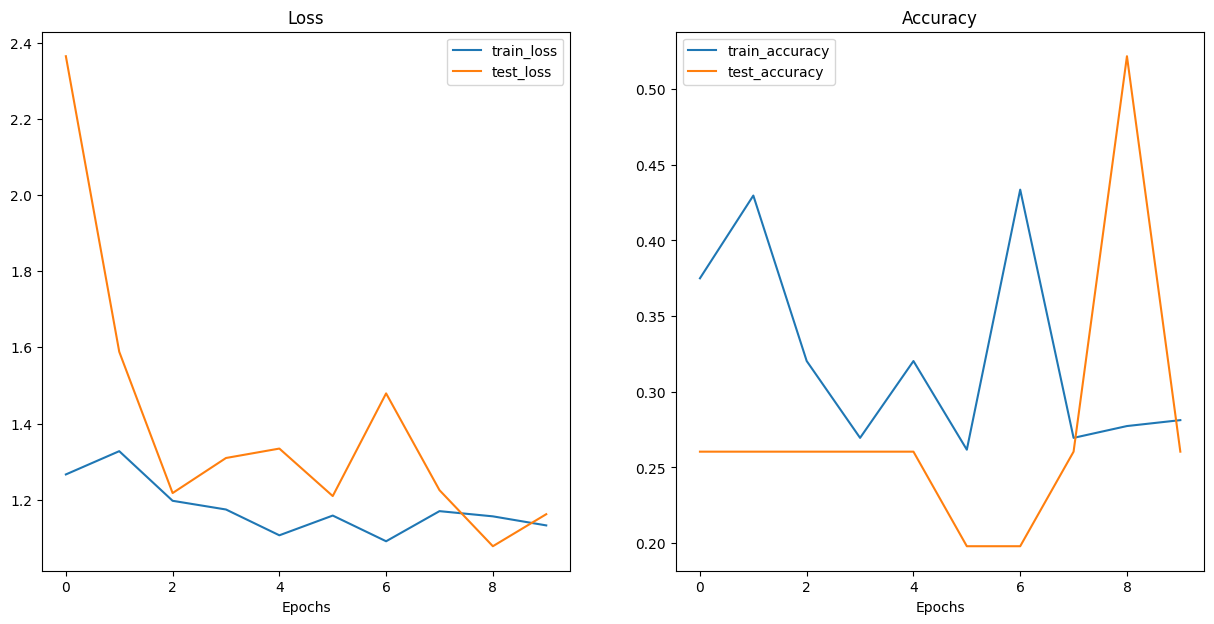

In [68]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

### Using pretrained ViT from torchvision.models on same dataset

In [70]:
#1. Get pretrained weight for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

#2. Setup ViT model instance with weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

#3. Freeze base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
#4. Change classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

pretrained_vit

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /home/joseph/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 58.1MB/s] 


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [71]:
summary(model=pretrained_vit,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [72]:
print(image_path)
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

data/pizza_steak_sushi


(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [73]:
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [74]:
#Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)

### Train feature extractor of ViT model

In [80]:
from going_modular.going_modular import engine
set_seeds()

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                                 lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

#Train classifier head of pretrained ViT feature extractor model
pretrained_vit_results = engine.train(
    model=pretrained_vit,
    train_dataloader=train_dataloader_pretrained,
    test_dataloader=test_dataloader_pretrained,
    epochs=10,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device
)

 10%|█         | 1/10 [00:02<00:22,  2.48s/it]

Epoch: 1 | train_loss: 0.7466 | train_acc: 0.7500 | test_loss: 0.5321 | test_acc: 0.8665


 20%|██        | 2/10 [00:04<00:19,  2.47s/it]

Epoch: 2 | train_loss: 0.3356 | train_acc: 0.9453 | test_loss: 0.3219 | test_acc: 0.8977


 30%|███       | 3/10 [00:07<00:17,  2.48s/it]

Epoch: 3 | train_loss: 0.2032 | train_acc: 0.9531 | test_loss: 0.2685 | test_acc: 0.9081


 40%|████      | 4/10 [00:09<00:14,  2.48s/it]

Epoch: 4 | train_loss: 0.1536 | train_acc: 0.9570 | test_loss: 0.2411 | test_acc: 0.9081


 50%|█████     | 5/10 [00:12<00:12,  2.49s/it]

Epoch: 5 | train_loss: 0.1231 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977


 60%|██████    | 6/10 [00:14<00:09,  2.50s/it]

Epoch: 6 | train_loss: 0.1201 | train_acc: 0.9766 | test_loss: 0.2123 | test_acc: 0.9280


 70%|███████   | 7/10 [00:17<00:07,  2.49s/it]

Epoch: 7 | train_loss: 0.0925 | train_acc: 0.9766 | test_loss: 0.2348 | test_acc: 0.8883


 80%|████████  | 8/10 [00:19<00:04,  2.49s/it]

Epoch: 8 | train_loss: 0.0786 | train_acc: 0.9844 | test_loss: 0.2277 | test_acc: 0.8778


 90%|█████████ | 9/10 [00:22<00:02,  2.48s/it]

Epoch: 9 | train_loss: 0.1080 | train_acc: 0.9883 | test_loss: 0.2071 | test_acc: 0.9384


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]

Epoch: 10 | train_loss: 0.0640 | train_acc: 0.9922 | test_loss: 0.1804 | test_acc: 0.9176


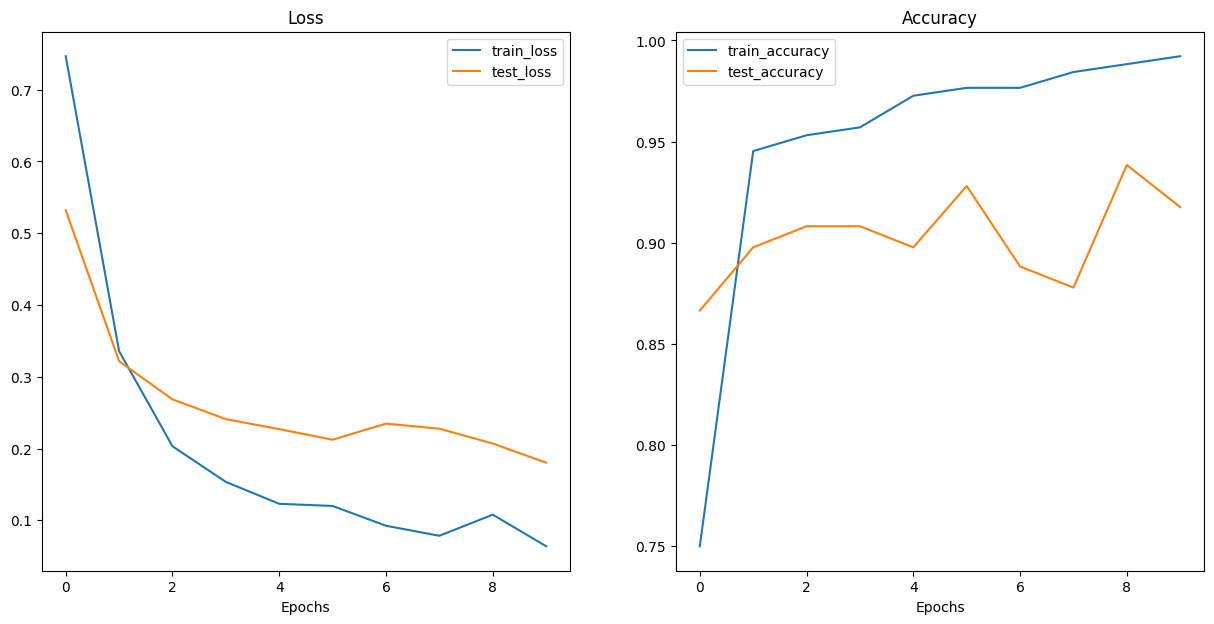

In [81]:
from helper_functions import plot_loss_curves
# Plot the loss curves
plot_loss_curves(pretrained_vit_results)


In [82]:
# Save model
from going_modular.going_modular import utils
utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [85]:
from pathlib import Path
pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024**2)
print(f"Model size: {pretrained_vit_model_size} MB")

Model size: 327 MB


### Predictions on custom image

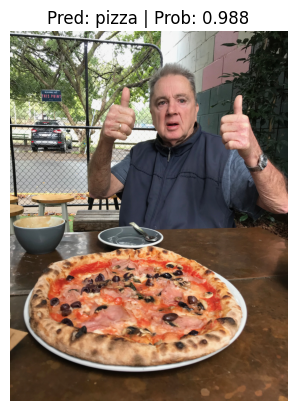

In [86]:
import requests

from going_modular.going_modular.predictions import pred_and_plot_image

custom_image_path = image_path / "04-pizza-dad.jepg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")
    
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)